In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import dustmaps.bayestar
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.io import fits, ascii
from dustmaps.config import config
from scipy.optimize import curve_fit 
import pandas as pd
import os
config.reset()

In [2]:
# Function to call coordinates and return distance axis and differential Av. To get total Av along a line a sight try np.sum(cdusts)*delta(dists).

def dust(l, b):
    # Return distance, differential Av along a line of sight provided:
    dists = np.linspace(100, 800, 700) #700 -> resolution of 1 pc
    cdusts = np.zeros_like(dists)
    for i, d in enumerate(dists):
        if (i != 0): 
            point = SkyCoord(l*u.deg, b*u.deg, distance=d*u.pc, frame='galactic')
            data, flags = b19.query(point, mode='mean', return_flags=True)
            cdusts[i]=data
    #dists = dists/1000 #pc to kpc conversion
    cdusts = cdusts-np.roll(cdusts, 1)
    return dists, cdusts

In [3]:
# You may have to download this map and it will take a long time. See dustmaps documentation.
import dustmaps.bayestar
dustmaps.bayestar.fetch()

Checking existing file to see if MD5 sum matches ...
File exists. Not overwriting.


In [4]:
def distmod_to_dist(distmod):
    return 10**(1 + distmod / 5)
# Change modulus to distance

In [5]:
# Load the Bayestar 19 dustmap
b19 = dustmaps.bayestar.BayestarQuery(max_samples=2, version='bayestar2019')

Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 15.230 s
  pix_info:   0.428 s
   samples:   5.005 s
      best:   2.699 s
       nan:   0.017 s
      sort:   7.002 s
       idx:   0.079 s


In [5]:
#Gaussian function, h = height, c = center, w = width 
def Gauss(x, h, c, w): 
    G = h*np.exp(-(x-c)**2/(2*w**2))
    return G

In [6]:
def plotred(l, b, bounds = (-np.inf, np.inf)):
    
    """Plot the differential reddening for a given Galactic coordinate (l, b)."""
    dists, cdusts = dust(l, b)
    cdusts = cdusts * 3.1 #multiply by Rv factor

    #max_Av = np.abs(cdusts[0])
    max_Av2 = np.max(cdusts) #using this so we can find where Av is approximately max, workaround for max_Av yielding an empty array
    max_Av_loc = dists[np.where(cdusts == max_Av2)] #location of highest col dens

    #Gaussian fitting portion
    x = np.linspace(np.min(dists), np.max(dists), 100) #x value for gaussian to plot along
    parsec_data = np.array(cdusts) #ensure array
    Av_data = np.array(dists) #extinction data
    parameters, covariance = curve_fit(Gauss, dists, cdusts, p0=[.2, float(max_Av_loc[0]), 50], bounds = bounds) #max Av loc is location of dust peak, of which we use as center
    fit_h = parameters[0] #height
    fit_c = parameters[1] #center
    fit_w = parameters[2] #width
    fit_y = Gauss(x, fit_h, fit_c, fit_w)
    #print('FWHM', fit_w)

    #total Av
    area = fit_h * fit_w * np.sqrt(2 * np.pi)  # Total Av from Gaussian fit
    tot_Av = area

    #Calculations
    ratio = 8.3e21 * u.cm**-2 * u.mag**-1 #Number from Listz 2014a (sec 4.2 of Nguyen 2018 "Dust-Gas Scaling Relations"
    Av = tot_Av*u.mag #total extinction
    NH = ratio*Av #Column density
    depth = float(fit_w)*u.pc #FWHM of gaussian = depth
    volumeDensity = NH/depth
    volumeDensity = volumeDensity.to('cm**-3')

    #pandas dataframe
    data = {
        'l': [l],
        'b': [b],
        'Total Av [mag]': [tot_Av],
        'Distance of Max Av [pc]': [max_Av_loc],
        'FWHM [pc]': [fit_w],
        'Column Density [cm^-2]': [NH.value],
        'Volume Density [cm^-3]': [volumeDensity.value]
    }
    df = pd.DataFrame(data)


    fig, ax = plt.subplots(figsize=(6, 4))
    ax.step(dists, cdusts, where='mid', label = 'Data')
    ax.step(x, fit_y, linestyle = '--', color = 'crimson', label = 'Gaussian Fit')
    ax.set_xlabel('Distance (pc)', size=12)
    ax.set_ylabel(r'$\Delta$ A$_{\mathrm{v}}$ [mag]', size=12)
    ax.set_title(f'Differential Av Towards l={l}, b={b}', size=12)
    ax.set_xlim([0, 800])
    ax.set_ylim([0, 0.05])
    ax.legend()
    plt.grid(True, linestyle = '--')
    plt.show()


    folder = "B19 Mapped Dust Outputs"
    filename = os.path.join(folder, f"Bayestar19_l{l}_b{b}_mapped.csv")
    df.to_csv(filename, index=False)
    print(cdusts[0])
    print('Amplitude:', fit_h)

    return df

    #print('Max Av is', max_Av, 'mag')
    #print('Max Av is at distance', max_Av_loc, 'pc')
    #print('Volume Density is:', volumeDensity)
    #print(cdusts)

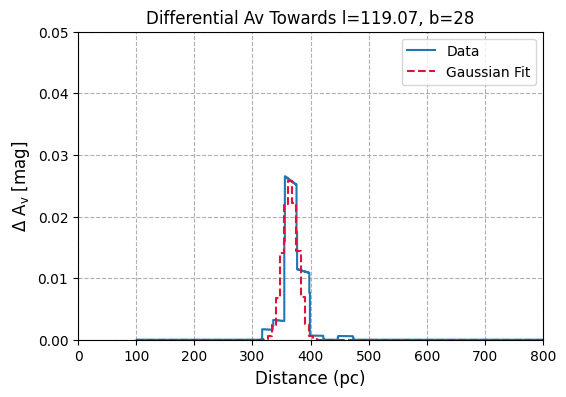

-0.9145000517368317
Amplitude: 0.025688462516072066


,l,b,Total Av [mag],Distance of Max Av [pc],FWHM [pc],Column Density [cm^-2],Volume Density [cm^-3]
0,119.07,28,0.839006,[356.3662374821173],13.029773,6.963747e+21,173.203073


In [8]:
plotred(119.07, 28)

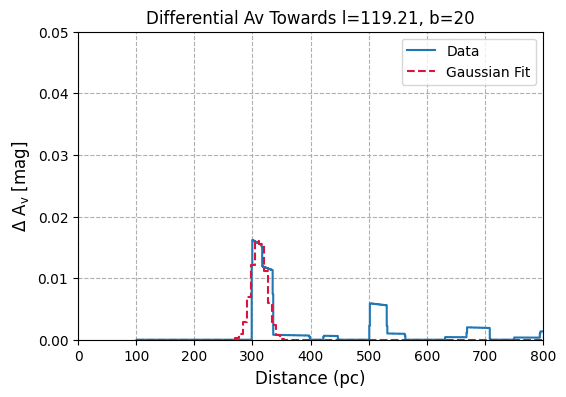

-0.8756630599498749
Amplitude: 0.016386154573229512


,l,b,Total Av [mag],Distance of Max Av [pc],FWHM [pc],Column Density [cm^-2],Volume Density [cm^-3]
0,119.21,20,0.531475,[300.28612303290413],12.939459,4.411245e+21,110.482763


In [9]:
plotred(119.21, 20)

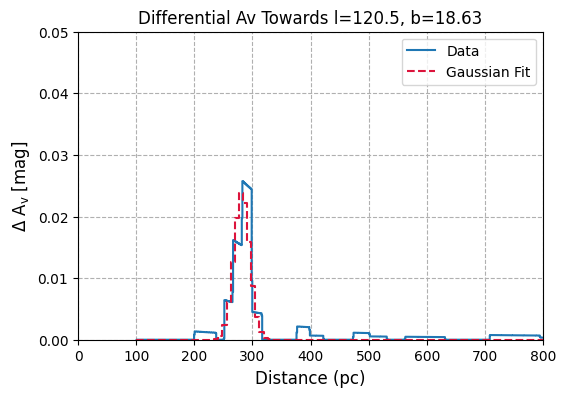

-1.0869158148765565
Amplitude: 0.023992157830872423


,l,b,Total Av [mag],Distance of Max Av [pc],FWHM [pc],Column Density [cm^-2],Volume Density [cm^-3]
0,120.5,18.63,0.831956,[283.26180257510725],13.83379,6.905236e+21,161.76583


In [10]:
plotred(120.5, 18.63)

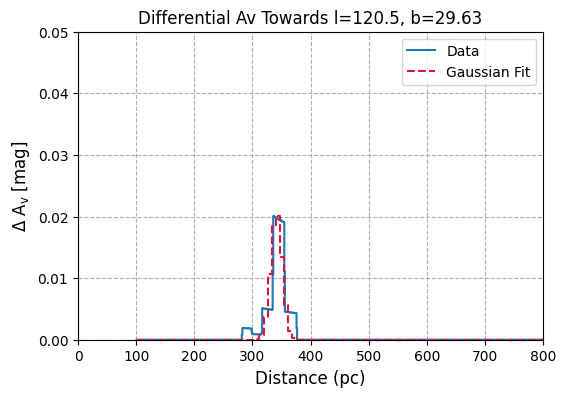

-0.6199999630451203
Amplitude: 0.020690872095397165


,l,b,Total Av [mag],Distance of Max Av [pc],FWHM [pc],Column Density [cm^-2],Volume Density [cm^-3]
0,120.5,29.63,0.528482,[336.3376251788269],10.189696,4.386398e+21,139.507089


In [11]:
plotred(120.5, 29.63)

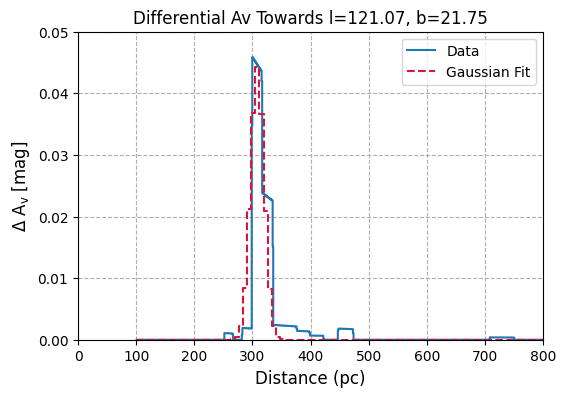

-1.4724999815225601
Amplitude: 0.04419273008487514


,l,b,Total Av [mag],Distance of Max Av [pc],FWHM [pc],Column Density [cm^-2],Volume Density [cm^-3]
0,121.07,21.75,1.286214,[300.28612303290413],11.61108,1.067558e+22,297.967099


In [12]:
plotred(121.07, 21.75)

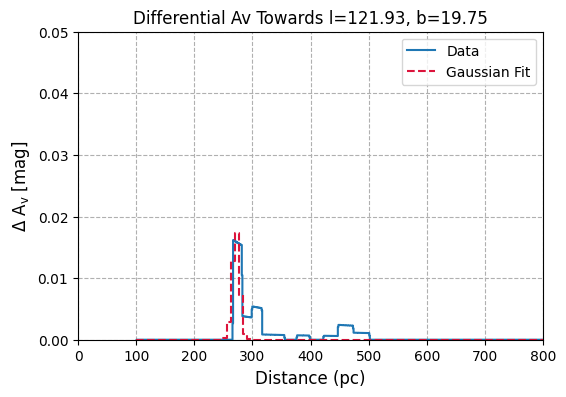

-0.5579999759793282
Amplitude: 0.017883944229171642


,l,b,Total Av [mag],Distance of Max Av [pc],FWHM [pc],Column Density [cm^-2],Volume Density [cm^-3]
0,121.93,19.75,0.291662,[267.23891273247494],6.506199,2.420799e+21,120.581529


In [13]:
plotred(121.93, 19.75)

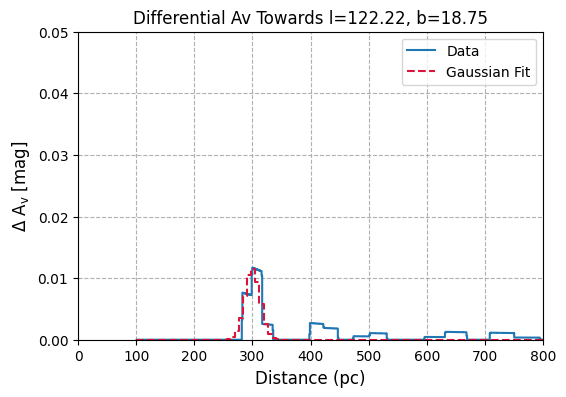

-0.6509999796748162
Amplitude: 0.011555741402695151


,l,b,Total Av [mag],Distance of Max Av [pc],FWHM [pc],Column Density [cm^-2],Volume Density [cm^-3]
0,122.22,18.75,0.377041,[300.28612303290413],13.01671,3.129443e+21,77.913963


In [14]:
plotred(122.22, 18.75)

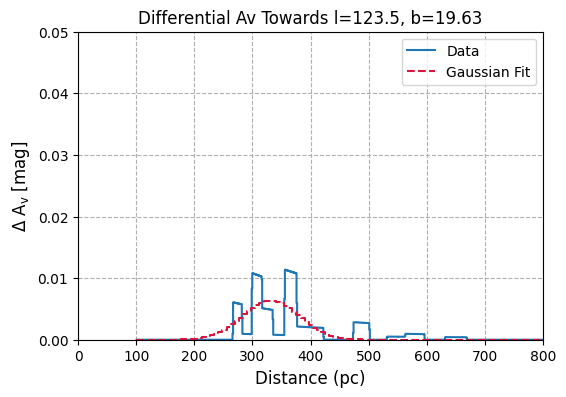

-0.868000003695488
Amplitude: 0.006360996877865173


,l,b,Total Av [mag],Distance of Max Av [pc],FWHM [pc],Column Density [cm^-2],Volume Density [cm^-3]
0,123.5,19.63,0.776805,[356.3662374821173],48.718866,6.447486e+21,42.888678


In [15]:
plotred(123.5, 19.63)

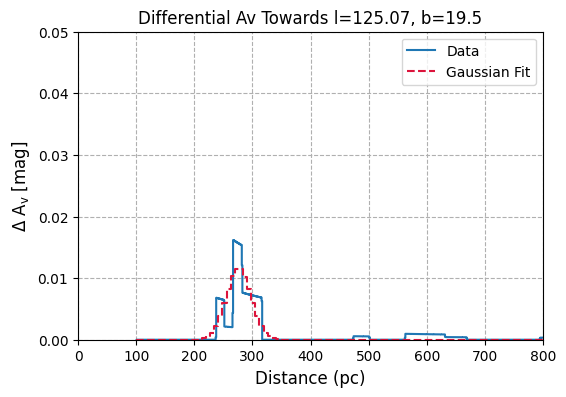

-0.7149157539010048
Amplitude: 0.011626532452565518


,l,b,Total Av [mag],Distance of Max Av [pc],FWHM [pc],Column Density [cm^-2],Volume Density [cm^-3]
0,125.07,19.5,0.623008,[267.23891273247494],21.377317,5.170963e+21,78.391268


In [16]:
plotred(125.07, 19.5)

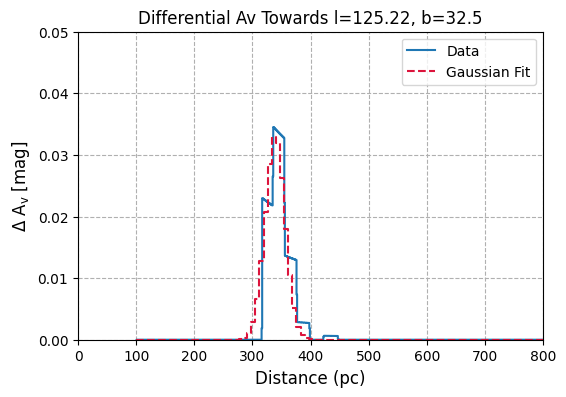

-1.4414999186992645
Amplitude: 0.03323012122850794


,l,b,Total Av [mag],Distance of Max Av [pc],FWHM [pc],Column Density [cm^-2],Volume Density [cm^-3]
0,125.22,32.5,1.419756,[336.3376251788269],17.044796,1.178397e+22,224.0523


In [17]:
plotred(125.22, 32.5)

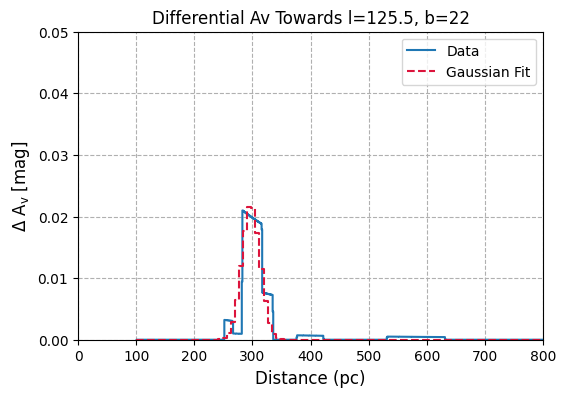

-0.961000007390976
Amplitude: 0.022037126111416703


,l,b,Total Av [mag],Distance of Max Av [pc],FWHM [pc],Column Density [cm^-2],Volume Density [cm^-3]
0,125.5,22,0.867756,[283.26180257510725],15.709148,7.202373e+21,148.584134


In [18]:
plotred(125.5, 22)

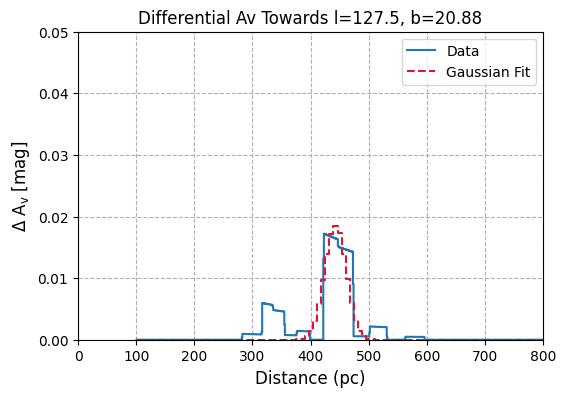

-1.177999985218048
Amplitude: 0.01851487999772726


,l,b,Total Av [mag],Distance of Max Av [pc],FWHM [pc],Column Density [cm^-2],Volume Density [cm^-3]
0,127.5,20.88,0.868955,[423.4620886981402],18.723483,7.212330e+21,124.83558


In [19]:
plotred(127.5, 20.88)

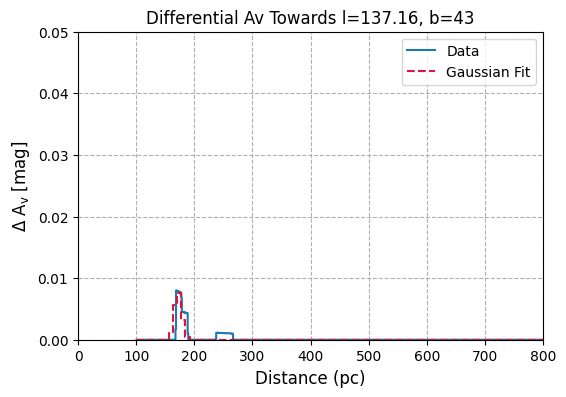

-0.15500000230968
Amplitude: 0.00781154392501748


,l,b,Total Av [mag],Distance of Max Av [pc],FWHM [pc],Column Density [cm^-2],Volume Density [cm^-3]
0,137.16,43,0.127827,[169.09871244635193],6.528231,1.060963e+21,52.668914


In [20]:
plotred(137.16, 43)

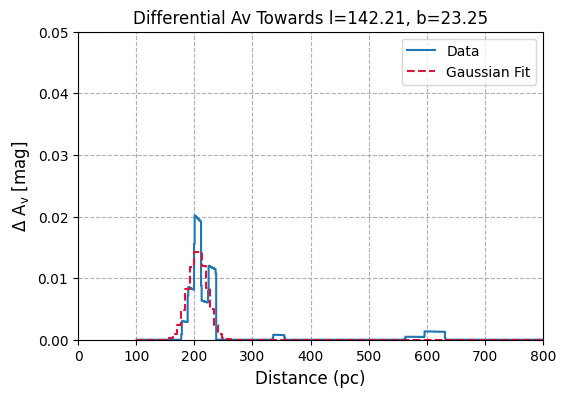

-0.666500011086464
Amplitude: 0.014521015074837936


,l,b,Total Av [mag],Distance of Max Av [pc],FWHM [pc],Column Density [cm^-2],Volume Density [cm^-3]
0,142.21,23.25,0.608938,[201.14449213161657],16.729626,5.054186e+21,97.907161


In [44]:
plotred(142.21, 23.25, bounds = [(0, 175, 0), (0.2, 230, 80)])

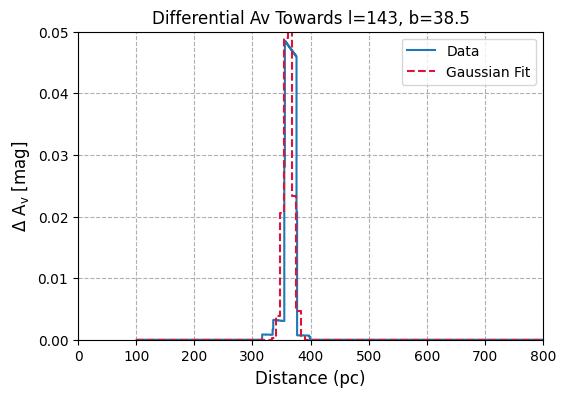

-1.0849999815225602
Amplitude: 0.0554475794371696


,l,b,Total Av [mag],Distance of Max Av [pc],FWHM [pc],Column Density [cm^-2],Volume Density [cm^-3]
0,143,38.5,1.082287,[356.3662374821173],7.786993,8.982980e+21,373.852314


In [22]:
plotred(143, 38.5)

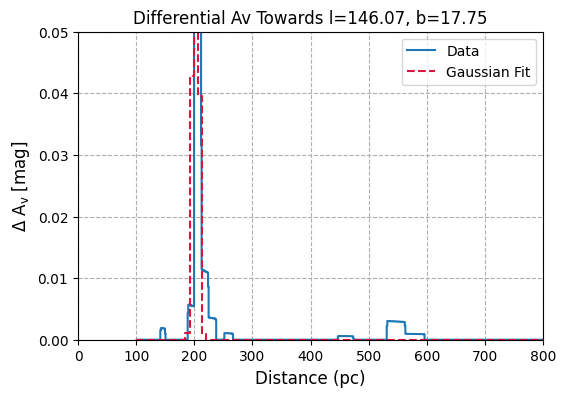

-1.8445000886917116
Amplitude: 0.14037028600907098


,l,b,Total Av [mag],Distance of Max Av [pc],FWHM [pc],Column Density [cm^-2],Volume Density [cm^-3]
0,146.07,17.75,1.588171,[201.14449213161657],4.513693,1.318182e+22,946.439083


In [23]:
plotred(146.07, 17.75, bounds = ([0, -180, 0], [1, 230, 50]))

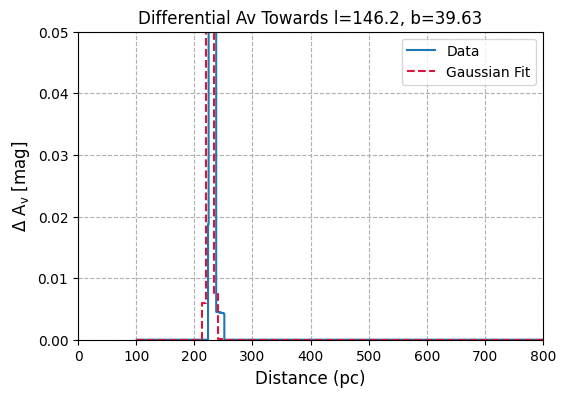

-0.8524999260902405
Amplitude: 0.07006410318311862


,l,b,Total Av [mag],Distance of Max Av [pc],FWHM [pc],Column Density [cm^-2],Volume Density [cm^-3]
0,146.2,39.63,0.860742,[225.17882689556507],4.901029,7.144155e+21,472.403437


In [24]:
plotred(146.2, 39.63)

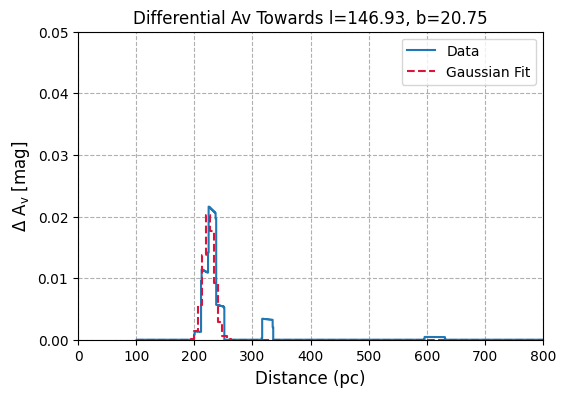

-0.588999992609024
Amplitude: 0.020490409115710092


,l,b,Total Av [mag],Distance of Max Av [pc],FWHM [pc],Column Density [cm^-2],Volume Density [cm^-3]
0,146.93,20.75,0.50539,[225.17882689556507],9.839787,4.194733e+21,138.155478


In [25]:
plotred(146.93, 20.75)

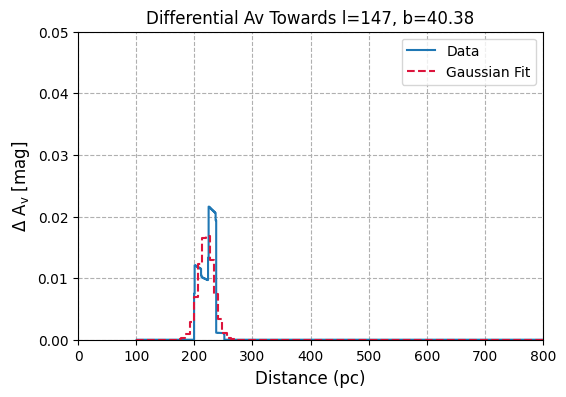

-0.5580000221729279
Amplitude: 0.017239609515926662


,l,b,Total Av [mag],Distance of Max Av [pc],FWHM [pc],Column Density [cm^-2],Volume Density [cm^-3]
0,147,40.38,0.577757,[225.17882689556507],13.369893,4.795384e+21,116.237137


In [26]:
plotred(147, 40.38)

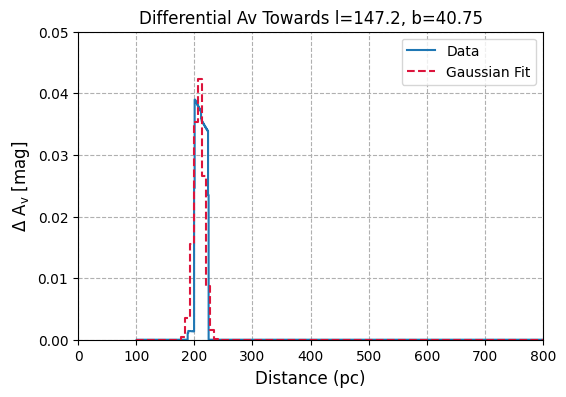

-0.8989999741315842
Amplitude: 0.04299305504101332


,l,b,Total Av [mag],Distance of Max Av [pc],FWHM [pc],Column Density [cm^-2],Volume Density [cm^-3]
0,147.2,40.75,0.948918,[201.14449213161657],8.805223,7.876018e+21,289.878355


In [27]:
plotred(147.2, 40.75)

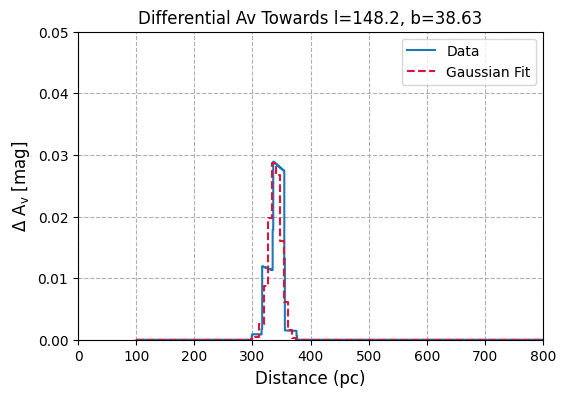

-0.8214999556541444
Amplitude: 0.02947757237238617


,l,b,Total Av [mag],Distance of Max Av [pc],FWHM [pc],Column Density [cm^-2],Volume Density [cm^-3]
0,148.2,38.63,0.784317,[336.3376251788269],10.614758,6.509833e+21,198.750942


In [28]:
plotred(148.2, 38.63)

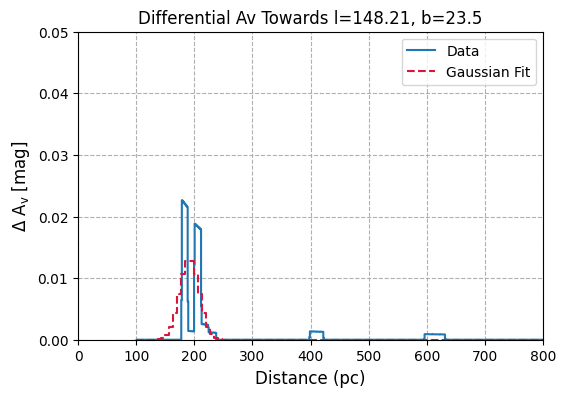

-0.573500007390976
Amplitude: 0.01304959993457514


,l,b,Total Av [mag],Distance of Max Av [pc],FWHM [pc],Column Density [cm^-2],Volume Density [cm^-3]
0,148.21,23.5,0.543488,[179.11301859799715],16.615095,4.510950e+21,87.986224


In [43]:
plotred(148.21, 23.5, bounds = [(0, 150, 0), (0.2, 220, 80)])

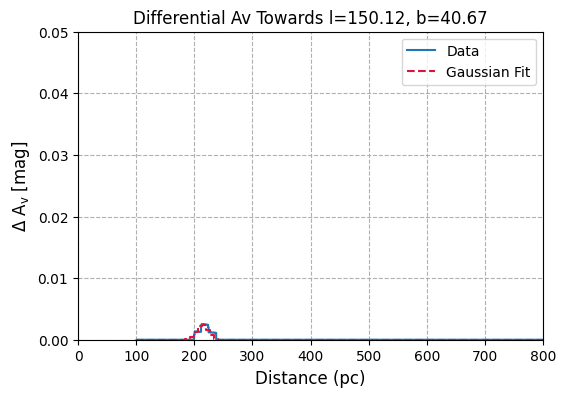

-0.06199999861419201
Amplitude: 0.0024102617684887548


,l,b,Total Av [mag],Distance of Max Av [pc],FWHM [pc],Column Density [cm^-2],Volume Density [cm^-3]
0,150.12,40.67,0.063453,[213.16165951359085],10.502651,5.266610e+20,16.25106


In [30]:
plotred(150.12, 40.67)

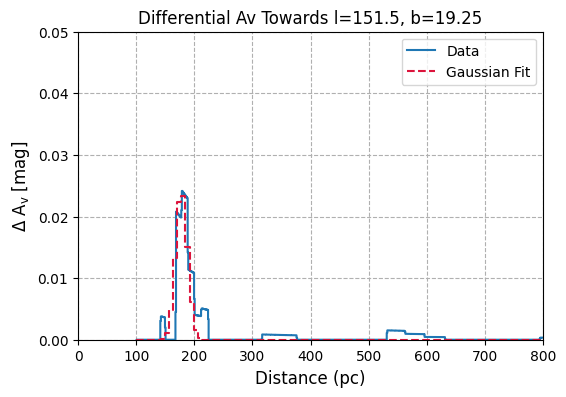

-0.8544157594442368
Amplitude: 0.024218329687107566


,l,b,Total Av [mag],Distance of Max Av [pc],FWHM [pc],Column Density [cm^-2],Volume Density [cm^-3]
0,151.5,19.25,0.62132,[179.11301859799715],10.234841,5.156955e+21,163.290782


In [31]:
plotred(151.5, 19.25, bounds = ([0, 150, 0], [0.2, 220, 50]))

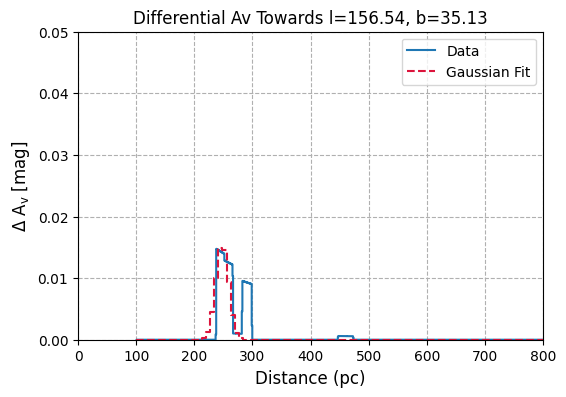

-0.573500007390976
Amplitude: 0.015607966215259571


,l,b,Total Av [mag],Distance of Max Av [pc],FWHM [pc],Column Density [cm^-2],Volume Density [cm^-3]
0,156.54,35.13,0.427502,[238.19742489270385],10.927035,3.548270e+21,105.23587


In [32]:
plotred(156.54, 35.13)

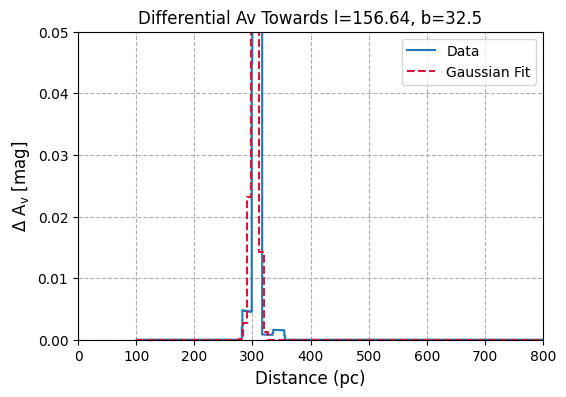

-1.131500029563904
Amplitude: 0.06682636128755594


,l,b,Total Av [mag],Distance of Max Av [pc],FWHM [pc],Column Density [cm^-2],Volume Density [cm^-3]
0,156.64,32.5,1.105502,[300.28612303290413],6.599662,9.175664e+21,450.573137


In [33]:
plotred(156.64, 32.5)

# Creating master Bayestar CSV Table

In [45]:
from glob import glob

In [46]:
def csv_combine(folder = "B19 Mapped Dust Outputs", output = "B19 Master DF.csv"):
    # gather csvs
    csv_files = glob(os.path.join(folder, "*.csv"))
    
    # Load and concatenate only the first row of each CSV
    dfs = [pd.read_csv(i).iloc[[0]] for i in csv_files]  # use [[0]] to keep it as a DataFrame
    combined_df = pd.concat(dfs, ignore_index=True)

    # Drop duplicates based on 'l' and 'b', keeping the first occurrence
    combined_df = combined_df.drop_duplicates(subset=['l', 'b'], keep='first')

    # Save out to master file
    combined_df.to_csv(os.path.join(folder, output), index=False)
    
    print(f"Combined {len(csv_files)} files into '{output}' with {len(combined_df)} rows.")
    return combined_df

In [47]:
folder = "B19 Mapped Dust Outputs"
output = "B19_Master_DF2.csv"

csv_combine(folder, output)

Combined 27 files into 'B19_Master_DF2.csv' with 26 rows.


,l,b,Total Av [mag],Distance of Max Av [pc],FWHM [pc],Column Density [cm^-2],Volume Density [cm^-3],Max Av [mag]
0,125.22,32.50,1.419756,[336.33762518],17.044796,1.178397e+22,224.052300,NaN
1,146.07,17.75,1.588171,[201.14449213],4.513693,1.318182e+22,946.439083,NaN
2,151.50,19.25,0.621320,[179.1130186],10.234841,5.156955e+21,163.290782,NaN
3,156.54,35.13,0.427502,[238.19742489],10.927035,3.548270e+21,105.235870,NaN
4,147.20,40.75,0.948918,[201.14449213],8.805223,7.876018e+21,289.878355,NaN
5,148.21,23.50,0.543488,[179.1130186],16.615095,4.510950e+21,87.986224,NaN
6,125.50,22.00,0.867756,[283.26180258],15.709148,7.202373e+21,148.584134,NaN
7,143.00,38.50,1.082287,[356.36623748],7.786993,8.982980e+21,373.852314,NaN
8,119.21,20.00,0.531475,[300.28612303],12.939459,4.411245e+21,110.482763,NaN
9,137.16,43.00,0.127827,[169.09871245],6.528231,1.060963e+21,52.668914,NaN
